In [2]:
import pandas as pd
import numpy as np
import re
import string

#import dataset
data = pd.read_csv("RateMyProfessor_Sample data.csv", usecols = ["comments", "student_star"])

#preprocessing
#remove all punctuation
data["comments"] = data["comments"].str.replace(r'[^\w\s]+', '', regex = True)
#make all letters lowercase
data["comments"] = data["comments"].str.lower()
#split each word (removed)
#data["comments"] = data["comments"].str.split()

#alter target attribute: any score 3.4 or above is considered a positive review
data['student_star'] = data['student_star'].where(data['student_star'] > 3.4, -1)
data['student_star'] = data['student_star'].where(data['student_star'] <= 3.4, 1)

X = data.iloc[:, -1]
y = data.iloc[:, :-1]

print(data)

       student_star                                           comments
0               1.0  this class is hard but its a twoinone gened kn...
1               1.0  definitely going to choose prof looneys class ...
2               1.0  i overall enjoyed this class because the assig...
3               1.0  yes its possible to get an a but youll definit...
4               1.0  professor looney has great knowledge in astron...
...             ...                                                ...
19995          -1.0            great sense of humor love parasites now
19996          -1.0  he is a really nice guy and is really funnyhow...
19997           1.0  his parasitology class is a lot of work but he...
19998           1.0  he is way too much work for a 1 credit class s...
19999           1.0  extremely easy lab teacher quizzes are a littl...

[20000 rows x 2 columns]


In [3]:
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#list of stop words
stop_str = (['the', 'a', 'and', 'to', 'you', 'is', 'class', 'he', 'she', 'of', 'an', 'in',
            'but', 'his', 'her', 'was', 'have', 'with', 'take', 'with', 'that', 'do', 'be',
            'for', 'if', 'it', 'are', 'on', 'this', 'will', 'at', 'about', 'as', 'so', 'guy',
            'him', 'your', 'had', 'can', 'hes', 'from', 'me', 'its', 'shes', 'get', 'my'])

cv = CountVectorizer(stop_words = stop_str)
tfidf_transformer = TfidfTransformer()


#bag of words
X_bow = cv.fit_transform(X.values.astype('U'))
X_bow.shape

(20000, 19924)

There are 20000 total records.
There are 12932 positive records.
There are 7068 negative records.
64.66% of records in the dataset are positive.



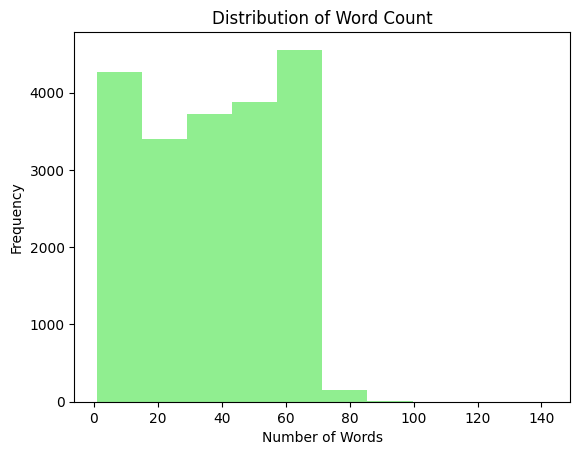


There are 19924 unique words.

The 25 most common words, excluding stop words, are: 
[('very', 7368), ('not', 6357), ('teacher', 4005), ('professor', 3859), ('easy', 3464), ('great', 3382), ('really', 3358), ('all', 3175), ('good', 3002), ('students', 2656), ('no', 2633), ('hard', 2601), ('what', 2549), ('tests', 2523), ('dont', 2300), ('one', 2257), ('just', 2219), ('work', 2155), ('lot', 2099), ('help', 2015), ('best', 1948), ('like', 1905), ('time', 1885), ('lectures', 1784), ('would', 1764)]


In [4]:
#analysis of dataset
#class distribution, text length distribution, total unique words, most common words
import matplotlib.pyplot as plt

#print('The accuracy for Naive Bayes classifier using TF-IDF is {:.5f} on training data'.format(accuracy_score(y_pred = clf.predict(X_train), y_true = y_train)))
pos_ct = sum(data['student_star'] > 0)
neg_ct = sum(data['student_star'] < 0)

print('There are {:.0f} total records.'.format( pos_ct + neg_ct ))
print('There are {:.0f} positive records.'.format( pos_ct ))
print('There are {:.0f} negative records.'.format( neg_ct ))
print('{:.2f}% of records in the dataset are positive.\n'.format( (pos_ct / (pos_ct + neg_ct)) * 100 ))

word_ct = pd.read_csv("RateMyProfessor_Sample data.csv", usecols = ["word_comment"])
plt.hist(word_ct, color='lightgreen', ec='black', bins=10)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Word Count")
plt.show()

print('\nThere are {:.0f} unique words.\n'.format( len(cv.get_feature_names_out()) ))

print('The 25 most common words, excluding stop words, are: ')
freqs = zip(cv.get_feature_names_out(), X_bow.sum(axis=0).tolist()[0])
# sort from largest to smallest
print( sorted(freqs, key=lambda x: -x[1]) [:25])

In [5]:
#training classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#train-test split with Bag of Words, then apply TF-IDF to have same set of sample data
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size = 0.2)

y_train_arr = y_train.to_numpy().reshape(-1)

X_tfidf_train = tfidf_transformer.fit_transform(X_bow_train)
X_tfidf_train.shape
X_tfidf_test = tfidf_transformer.fit_transform(X_bow_test)
X_tfidf_test.shape

print('Classifier\t Feature Extr.\t Train Acc.\t Test Acc.')
print('---------------------------------------------------------')

#naive bayes
from sklearn.naive_bayes import MultinomialNB
clf_bow = MultinomialNB().fit(X_bow_train, y_train_arr)
clf_tfidf = MultinomialNB().fit(X_tfidf_train, y_train_arr)
print('Naive Bayes\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = clf_bow.predict(X_bow_train), y_true = y_train),
                                                              accuracy_score(y_pred = clf_bow.predict(X_bow_test), y_true = y_test)))
print('Naive Bayes\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                                 accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_test), y_true = y_test)))

print('---------------------------------------------------------')
#support vector machine
from sklearn.linear_model import SGDClassifier
svm_bow = SGDClassifier().fit(X_bow_train, y_train_arr)
svm_tfidf = SGDClassifier().fit(X_tfidf_train, y_train_arr)
print('SVM\t\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svm_bow.predict(X_bow_train), y_true = y_train),
                                                          accuracy_score(y_pred = svm_bow.predict(X_bow_test), y_true = y_test)))
print('SVM\t\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                             accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_test), y_true = y_test)))


print('---------------------------------------------------------')
#logistic regression
from sklearn.linear_model import LogisticRegression
lr_bow = LogisticRegression().fit(X_bow_train, y_train_arr)
lr_tfidf = LogisticRegression().fit(X_tfidf_train, y_train_arr)
print('Log Regression\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = lr_bow.predict(X_bow_train), y_true = y_train),
                                               accuracy_score(y_pred = lr_bow.predict(X_bow_test), y_true = y_test)))
print('Log Regression\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = lr_tfidf.predict(X_tfidf_train), y_true = y_train),
                                               accuracy_score(y_pred = lr_tfidf.predict(X_tfidf_test), y_true = y_test)))

print('---------------------------------------------------------')
#linear support vector classification
from sklearn.svm import LinearSVC
svc_bow = LinearSVC(max_iter = 2000).fit(X_bow_train, y_train_arr)
svc_tfidf = LinearSVC().fit(X_tfidf_train, y_train_arr)
print('SVC\t\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svc_bow.predict(X_bow_train), y_true = y_train),
                                               accuracy_score(y_pred = svc_bow.predict(X_bow_test), y_true = y_test)))
print('SVC\t\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                  accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_test), y_true = y_test)))



Classifier	 Feature Extr.	 Train Acc.	 Test Acc.
---------------------------------------------------------
Naive Bayes	 BoW		 0.88031	 0.84200
Naive Bayes	 TF-IDF		 0.80781	 0.76450
---------------------------------------------------------
SVM		 BoW		 0.93769	 0.81900
SVM		 TF-IDF		 0.89581	 0.84000
---------------------------------------------------------
Log Regression	 BoW		 0.92725	 0.82800
Log Regression	 TF-IDF		 0.88113	 0.80825
---------------------------------------------------------
SVC		 BoW		 0.96306	 0.80825
SVC		 TF-IDF		 0.93788	 0.82950


In [6]:
#hyperparameter testing
from sklearn.model_selection import GridSearchCV
print('Testing for hyperparameters:')

#naive bayes
clf_param = {
    'fit_prior': (True, False),
    'force_alpha': (True, False),
    'alpha': (1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1),
}

gs_clf = GridSearchCV(clf_tfidf, clf_param, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_tfidf_train, y_train_arr)
print('Naive Bayes:')
for param_name in sorted(clf_param.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print('---------------------------------------------------------')



#support vector machine
svm_param = {
    'max_iter': (1500, 1000, 500),
    'loss': ('hinge', 'perceptron', 'squared_error'),
    'alpha': (0.01, 0.005, 0.001),
}

gs_svm = GridSearchCV(svm_tfidf, svm_param, cv=5, n_jobs=-1)
gs_svm = gs_svm.fit(X_tfidf_train, y_train_arr)
print('SVM:')
for param_name in sorted(svm_param.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))
print('---------------------------------------------------------')



#logistic regression
lr_param = {
    'solver': ('lbfgs', 'liblinear', 'newton-cg'),
    'max_iter': (500, 750, 1000, 1250)
}

gs_lr = GridSearchCV(lr_tfidf, lr_param, cv=5, n_jobs=-1)
gs_lr = gs_lr.fit(X_tfidf_train, y_train_arr)
print('Logistic Regression:')
for param_name in sorted(lr_param.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))
print('---------------------------------------------------------')



#linear support vector classification
svc_param = {
    'max_iter': (500, 750, 1000, 2000, 2500),
    'C': (0.01, 0.1, 0.5, 1.0, 1.5),
}

gs_svc = GridSearchCV(svc_tfidf, svc_param, cv=5, n_jobs=-1)
gs_svc = gs_svc.fit(X_tfidf_train, y_train_arr)
print('SVM:')
for param_name in sorted(svc_param.keys()):
    print("%s: %r" % (param_name, gs_svc.best_params_[param_name]))
print('---------------------------------------------------------')

Testing for hyperparameters:
Naive Bayes:
alpha: 0.5
fit_prior: False
force_alpha: True
---------------------------------------------------------
SVM:
alpha: 0.001
loss: 'squared_error'
max_iter: 1000
---------------------------------------------------------
Logistic Regression:
max_iter: 500
solver: 'liblinear'
---------------------------------------------------------
SVM:
C: 0.1
max_iter: 500
---------------------------------------------------------


In [7]:
#testing the optimized hyperparameters with TF-IDF
print('Results of applying tuned hyperparameters')
print('-----------------------------------------')

print('Classifier\tTrain Acc.\tTest Acc.')
clf_tfidf = MultinomialNB(alpha = 0.5).fit(X_tfidf_train, y_train_arr)
print('Naive Bayes\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                                 accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_test), y_true = y_test)))

svm_tfidf = SGDClassifier(alpha = 0.001, loss = 'squared_error', max_iter = 1000).fit(X_tfidf_train, y_train_arr)
print('SVM\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                             accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_test), y_true = y_test)))

lr_tfidf = LogisticRegression(solver = 'liblinear', max_iter = 500).fit(X_tfidf_train, y_train_arr)
print('Log Regression\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = lr_tfidf.predict(X_tfidf_train), y_true = y_train),
                                               accuracy_score(y_pred = lr_tfidf.predict(X_tfidf_test), y_true = y_test)))

svc_tfidf = LinearSVC(C = 0.1, max_iter = 500).fit(X_tfidf_train, y_train_arr)
print('SVC\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                  accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_test), y_true = y_test)))

Results of applying tuned hyperparameters
-----------------------------------------
Classifier	Train Acc.	Test Acc.
Naive Bayes	 0.85906	 0.80500
SVM		 0.84969	 0.83125
Log Regression	 0.88169	 0.80825
SVC		 0.88344	 0.84475


In [199]:
from sklearn.metrics import accuracy_score, classification_report
#WITHOUT TUNING

# Logistic Regression
m_lr = LogisticRegression()
m_lr.fit(X_tfidf_train, y_train)
# Predictions
y_pred_lr_train = m_lr.predict(X_tfidf_train)
y_pred_lr_test = m_lr.predict(X_tfidf_test)

# Accuracy scores
lr_train_accuracy = accuracy_score(y_train, y_pred_lr_train)
lr_test_accuracy = accuracy_score(y_test, y_pred_lr_test)

# Print formatted output
print("Logistic Regression\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lr_train_accuracy, lr_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lr_test))



# Linear SVC
m_svc = LinearSVC()
m_svc.fit(X_tfidf_train, y_train)
# Predictions
y_pred_svc_train = m_svc.predict(X_tfidf_train)
y_pred_svc_test = m_svc.predict(X_tfidf_test)

# Accuracy scores
svc_train_accuracy = accuracy_score(y_train, y_pred_svc_train)
svc_test_accuracy = accuracy_score(y_test, y_pred_svc_test)

# Print formatted output
print("Linear SVC\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(svc_train_accuracy, svc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svc_test))



# Support vector machine
m_svm = SGDClassifier()
m_svm.fit(X_tfidf_train, y_train)
# Predictions
y_pred_svm_train = m_svm.predict(X_tfidf_train)
y_pred_svm_test = m_svm.predict(X_tfidf_test)

# Accuracy scores
svm_train_accuracy = accuracy_score(y_train, y_pred_svm_train)
svm_test_accuracy = accuracy_score(y_test, y_pred_svm_test)

# Print formatted output
print("Support Vector Machine\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(svm_train_accuracy, svm_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm_test))



# naive bayes
m_clf = MultinomialNB()
m_clf.fit(X_tfidf_train, y_train)
# Predictions
y_pred_clf_train = m_clf.predict(X_tfidf_train)
y_pred_clf_test = m_clf.predict(X_tfidf_test)

# Accuracy scores
clf_train_accuracy = accuracy_score(y_train, y_pred_clf_train)
clf_test_accuracy = accuracy_score(y_test, y_pred_clf_test)

# Print formatted output
print("Naive Bayes\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(clf_train_accuracy, clf_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_clf_test))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression	 Train Accuracy: 0.88113	 Test Accuracy: 0.84225
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.84      0.69      0.76      1424
         1.0       0.84      0.93      0.88      2576

    accuracy                           0.84      4000
   macro avg       0.84      0.81      0.82      4000
weighted avg       0.84      0.84      0.84      4000



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear SVC	 Train Accuracy: 0.93788	 Test Accuracy: 0.82950
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.80      0.69      0.74      1424
         1.0       0.84      0.90      0.87      2576

    accuracy                           0.83      4000
   macro avg       0.82      0.80      0.81      4000
weighted avg       0.83      0.83      0.83      4000

Support Vector Machine	 Train Accuracy: 0.89619	 Test Accuracy: 0.84075


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.83      0.69      0.76      1424
         1.0       0.85      0.92      0.88      2576

    accuracy                           0.84      4000
   macro avg       0.84      0.81      0.82      4000
weighted avg       0.84      0.84      0.84      4000

Naive Bayes	 Train Accuracy: 0.80781	 Test Accuracy: 0.76450
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.94      0.36      0.52      1424
         1.0       0.74      0.99      0.84      2576

    accuracy                           0.76      4000
   macro avg       0.84      0.67      0.68      4000
weighted avg       0.81      0.76      0.73      4000



In [200]:
from sklearn.metrics import accuracy_score, classification_report
#WITH TUNING


# Logistic Regression
# Predictions
y_pred_lr_train = gs_lr.predict(X_tfidf_train)
y_pred_lr_test = gs_lr.predict(X_tfidf_test)

# Accuracy scores
lr_train_accuracy = accuracy_score(y_train, y_pred_lr_train)
lr_test_accuracy = accuracy_score(y_test, y_pred_lr_test)

print ("Logistic Regression")
for param_name in sorted(lr_param.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))
print('---------------------------------------------------------')

# Print formatted output
print("Logistic Regression\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lr_train_accuracy, lr_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lr_test))



# Linear SVC
# Predictions
y_pred_svc_train = gs_svc.predict(X_tfidf_train)
y_pred_svc_test = gs_svc.predict(X_tfidf_test)

# Accuracy scores
svc_train_accuracy = accuracy_score(y_train, y_pred_svc_train)
svc_test_accuracy = accuracy_score(y_test, y_pred_svc_test)

print ("Linear SVC")
for param_name in sorted(svc_param.keys()):
    print("%s: %r" % (param_name, gs_svc.best_params_[param_name]))
print('---------------------------------------------------------')

# Print formatted output
print("Linear SVC\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(svc_train_accuracy, svc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svc_test))



# Support vector machine
# Predictions
y_pred_svm_train = gs_svm.predict(X_tfidf_train)
y_pred_svm_test = gs_svm.predict(X_tfidf_test)

# Accuracy scores
svm_train_accuracy = accuracy_score(y_train, y_pred_svm_train)
svm_test_accuracy = accuracy_score(y_test, y_pred_svm_test)

print("Support Vector Machine")
for param_name in sorted(svm_param.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))
print('---------------------------------------------------------')

# Print formatted output
print("Support Vector Machine\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(svm_train_accuracy, svm_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm_test))



# naive bayes
# Predictions
y_pred_clf_train = gs_clf.predict(X_tfidf_train)
y_pred_clf_test = gs_clf.predict(X_tfidf_test)

# Accuracy scores
clf_train_accuracy = accuracy_score(y_train, y_pred_clf_train)
clf_test_accuracy = accuracy_score(y_test, y_pred_clf_test)

print("Naive Bayes")
for param_name in sorted(clf_param.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print('---------------------------------------------------------')

# Print formatted output
print("Naive Bayes\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(clf_train_accuracy, clf_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_clf_test))

Logistic Regression
max_iter: 500
solver: 'liblinear'
---------------------------------------------------------
Logistic Regression	 Train Accuracy: 0.88169	 Test Accuracy: 0.84200
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.84      0.69      0.76      1424
         1.0       0.84      0.93      0.88      2576

    accuracy                           0.84      4000
   macro avg       0.84      0.81      0.82      4000
weighted avg       0.84      0.84      0.84      4000

Linear SVC
C: 0.1
max_iter: 500
---------------------------------------------------------
Linear SVC	 Train Accuracy: 0.88344	 Test Accuracy: 0.84475
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.85      0.69      0.76      1424
         1.0       0.84      0.93      0.89      2576

    accuracy                           0.84      4000
   macro avg       0.85      0.81      0.82      4000
weighted avg       0.8

In [9]:
#deep
#import pandas as pd
import torch
from torch.utils.data import Dataset # Used implicitly by Hugging Face Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PreTrainedModel # Type hinting for return
)
!pip install datasets
from datasets import Dataset as HFDataset # Import Hugging Face's Dataset
from sklearn.model_selection import train_test_split
#import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import os
import sys


In [189]:
# Code used from Vincent

# Models/sentiment_trainer_function.py
# Tokenization Function for map()
def tokenize_function(examples, tokenizer, max_len):
    """Applies tokenizer to examples in a batch."""
    return tokenizer(
        examples["text"],
        padding="max_length", # Pad to max_length
        truncation=True,      # Truncate if longer than max_length
        max_length=max_len,
    )

# Define Metrics Calculation
def compute_metrics(eval_pred):
    """Computes classification metrics from predictions."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Use 'binary' average for 2-class problems
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


# --- Training Function ---

def train_amazon_sentiment_transformer(
    X_train_raw: pd.Series,
    X_val_raw: pd.Series,
    X_test_raw: pd.Series,
    y_train: pd.Series,
    y_val: pd.Series,
    y_test: pd.Series,
    model_name: str = 'bert-base-uncased',
    output_dir: str = './results_amazon_sentiment',
    num_train_epochs: int = 3,
    per_device_train_batch_size: int = 16,
    per_device_eval_batch_size: int = 16,
    max_len: int = 128,
):

    """
    Trains a Hugging Face Transformer for sentiment analysis on pre-split data
    and returns the trained model.

    Args:
        X_train_raw (pd.Series): Pandas Series containing raw training text reviews.
        X_val_raw (pd.Series): Pandas Series containing raw validation text reviews.
        X_test_raw (pd.Series): Pandas Series containing raw testing text reviews.
        y_train (pd.Series): Pandas Series containing training labels.
        y_val (pd.Series): Pandas Series containing validation labels.
        y_test (pd.Series): Pandas Series containing testing labels.
        model_name (str): Name of the pre-trained model from Hugging Face Hub.
        output_dir (str): Directory to save training checkpoints and results.
        num_train_epochs (int): Total number of training epochs.
        per_device_train_batch_size (int): Batch size per GPU/CPU for training.
        per_device_eval_batch_size (int): Batch size per GPU/CPU for evaluation.
        max_len (int): Maximum sequence length for tokenizer padding/truncation.
        # Add more args matching TrainingArguments parameters

    Returns:
        PreTrainedModel: The trained Hugging Face Transformer model.
    """
    print(f"\n--- Starting Transformer Training Process ---")
    print(f"Model: {model_name}, Output Dir: {output_dir}, Epochs: {num_train_epochs}")
    print(f"Training data size: {len(X_train_raw)}")
    print(f"Validation data size: {len(X_val_raw)}")
    print(f"Testing data size: {len(X_test_raw)}")


    # Convert pandas Series to Hugging Face Dataset format
    print("\nCreating Hugging Face Datasets from splits...")
    y_train = y_train['student_star'].astype(int)
    y_val = y_val['student_star'].astype(int)
    y_test = y_test['student_star'].astype(int)
    train_dict = {'text': X_train_raw['comments'].tolist(), 'label': y_train.tolist()}
    val_dict = {'text': X_val_raw['comments'].tolist(), 'label': y_val.tolist()}
    test_dict = {'text': X_test_raw['comments'].tolist(), 'label': y_test.tolist()} # Keep test set as HF dataset too

    train_dataset = HFDataset.from_pandas(pd.DataFrame(train_dict))
    val_dataset = HFDataset.from_pandas(pd.DataFrame(val_dict))
    test_dataset = HFDataset.from_pandas(pd.DataFrame(test_dict))

    #train_dataset = HFDataset.from_dict(train_dict)
    #val_dataset = HFDataset.from_dict(val_dict)
    #test_dataset = HFDataset.from_dict(test_dict)

 #   from datasets import Dataset
 #   train_dataset = Dataset.from_pandas(X_train_raw)
 #   val_dataset = Dataset.from_pandas(X_val_raw)
 #   test_dataset = Dataset.from_pandas(X_test_raw)

    print("Hugging Face Datasets created.")


    # Initialize Tokenizer
    print(f"\nLoading tokenizer: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)


    # Apply tokenization to datasets using map()
    print("Tokenizing datasets...")
    # Use lambda to pass tokenizer and max_len to tokenize_function
    tokenized_train_dataset = train_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    tokenized_val_dataset = val_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    tokenized_test_dataset = test_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    print("Tokenization complete.")


    # --- Model Loading ---
    print(f"\nLoading pre-trained model: {model_name} for sequence classification...")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    print("Model loaded.")

    # --- Training Arguments ---
    print("\nDefining Training Arguments...")
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,          # Output directory for checkpoints and results
        eval_strategy="epoch",          # Evaluate every epoch
        save_strategy="epoch",          # Save checkpoint every epoch
        save_total_limit=2,             # Limit the number of checkpoints to keep (e.g., keep last 2)
        num_train_epochs=num_train_epochs, # Total number of training epochs
        per_device_train_batch_size=per_device_train_batch_size, # Batch size per GPU/CPU for training
        per_device_eval_batch_size=per_device_eval_batch_size,  # Batch size per GPU/CPU for evaluation
        # Add other common arguments or make them function parameters
        learning_rate=2e-5,             # Default learning rate
        warmup_steps=500,               # Default warmup steps
        weight_decay=0.01,              # Default weight decay
        logging_dir=f'{output_dir}/logs',# Directory for storing logs
        logging_steps=10,               # Log every N update steps
        fp16=torch.cuda.is_available(), # Enable mixed precision training if CUDA is available
        load_best_model_at_end=True,    # Load the best model found during training at the end
        metric_for_best_model="accuracy", # Metric to monitor for best model saving
        greater_is_better=True,         # Whether the metric is better when greater
        report_to="none"                # Prevent reporting to external services by default
    )
    print("Training Arguments defined.")

    # --- Initialize the Trainer ---
    print("\nInitializing Trainer...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    print("Trainer initialized.")

    # --- Train the Model ---
    print("\n--- Starting Model Training ---")
    trainer.train()
    print("--- Training Complete ---")

    # --- Final Evaluation on Test Set ---
    print("\n--- Performing Final Evaluation on Test Set ---")
    # Evaluate on the test set that was held out
    test_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
    print(f"Transformer Test Results: {test_results}")
    print("--- Test Evaluation Complete ---")


    # Return the trained model (loaded with best weights if load_best_model_at_end=True)
    print("\nReturning the trained Transformer model.")
    return trainer.model

In [195]:
# Fit and transform the text data
X_tf = data[['comments']].copy()
X_tf = X_tf.astype(str)

X_tf = X_tf.sample(n = 3000, random_state=1)

y_tf = data[['student_star']].copy()
y_tf = y_tf.sample(n = 3000, random_state=1)

y_tf = y_tf.astype(np.int64)
#y_tf = data['student_star'].astype(np.int64)
y_tf = y_tf.where(data['student_star'] == 1, 0)
y_tf = y_tf.where(data['student_star'] == -1, 1)
y_tf = y_tf.fillna(-1)

#y_tf = y_tf.astype(bytes)
print(y_tf)


# splitting into train and test data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X_tf, y_tf, stratify=y_tf, test_size=0.2, random_state=30
)

# for the transformer
X_train_tf, X_val, y_train_tf, y_val = train_test_split(
    X_train_tf, y_train_tf, stratify=y_train_tf, test_size=0.2, random_state=30
)

transformer_params = {
            'X_train_raw': X_train_tf,
            'X_val_raw': X_val,
            'X_test_raw': X_test_tf,
            'y_train': y_train_tf,
            'y_val': y_val,
            'y_test': y_test_tf,
            'model_name': 'distilbert-base-uncased'
        }
transformer_model = train_amazon_sentiment_transformer(**transformer_params)


       student_star
11456             1
16528             1
3253              1
18614             1
1544              1
...             ...
319               1
1041              0
12180             0
18058             0
5399              0

[3000 rows x 1 columns]

--- Starting Transformer Training Process ---
Model: distilbert-base-uncased, Output Dir: ./results_amazon_sentiment, Epochs: 3
Training data size: 1920
Validation data size: 480
Testing data size: 600

Creating Hugging Face Datasets from splits...
Hugging Face Datasets created.

Loading tokenizer: distilbert-base-uncased...
Tokenizing datasets...


Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Tokenization complete.

Loading pre-trained model: distilbert-base-uncased for sequence classification...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-189-6c26884f7600>:161: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model loaded.

Defining Training Arguments...
Training Arguments defined.

Initializing Trainer...
Trainer initialized.

--- Starting Model Training ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.561300,0.549226,0.668750,0.665966,1.000000,0.799496
2,0.366000,0.353282,0.837500,0.919298,0.826498,0.870432
3,0.443800,0.384858,0.827083,0.817935,0.949527,0.878832


--- Training Complete ---

--- Performing Final Evaluation on Test Set ---


Transformer Test Results: {'eval_loss': 0.3661031126976013, 'eval_accuracy': 0.8166666666666667, 'eval_precision': 0.8847184986595175, 'eval_recall': 0.8312342569269522, 'eval_f1': 0.8571428571428571, 'eval_runtime': 127.2279, 'eval_samples_per_second': 4.716, 'eval_steps_per_second': 0.299, 'epoch': 3.0}
--- Test Evaluation Complete ---

Returning the trained Transformer model.


In [211]:
# Save the trained model
transformer_model_path = "/content/testModel2/"  # Specify a path to save the model
# transformer_model.save_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained(transformer_model_path)

('/content/testModel2/tokenizer_config.json',
 '/content/testModel2/special_tokens_map.json',
 '/content/testModel2/vocab.txt',
 '/content/testModel2/added_tokens.json',
 '/content/testModel2/tokenizer.json')

In [215]:
'''
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the path where the model is saved
model_path = "/content/testModel2"

# Load the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer (this is important for proper tokenization)
tokenizer = AutoTokenizer.from_pretrained(model_path)
'''

'\nfrom transformers import AutoModelForSequenceClassification, AutoTokenizer\n\n# Define the path where the model is saved\nmodel_path = "/content/testModel2"\n\n# Load the saved model\nmodel = AutoModelForSequenceClassification.from_pretrained(model_path)\n\n# Load the tokenizer (this is important for proper tokenization)\ntokenizer = AutoTokenizer.from_pretrained(model_path)\n'